# Computational Methods in Economics

## Lecture 6b - Multivariate Function Approximation

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2019-01-08 18:22:26.795850


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import IPython.display as display

import funapprox_cme as fa

# import sys
# from importlib import reload

**Note**: The last command imports the **funapprox_cme** module, which contains the functions defined in the last lecture. The Python-file **funapprox_cme.py** which can be downloaded from LSF must be saved in the same folder as this notebook.

## This Lecture

- [Multivariate Function Approximation](#funapprox2)
- [Further Topics](#misc)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'funapprox2'></a>

## Multivariate Function Approximation in Python

Recall that the general approximation problem that we want to solve is

\begin{equation}
   f(\mathbf{x}) \approx \hat{f}(\mathbf{x}) 
\end{equation}

for $\mathbf{x} \in [g_{min},g_{max}]^d \subset \mathbb{R}^d$. $f$ is defined on the *d-dimensional* interval 

\begin{equation}
    I = \{ (x_1, x_2, ..., x_d)\ |\ g_{min}^k \le x_k \le g_{max}^k, k = 1, ..., d \}
\end{equation}


When using interpolation, we stipulate an equality at a finite number of grid points:

\begin{equation}
   f(\mathbf{x}_i) = \hat{f}(\mathbf{x}_i) 
\end{equation}

As in the case of approximating a univariate function, we need basis functions to approximate $f$. We will consider two alternative approaches, tensor product and complete polynomials.

#### Tensor Product Basis

If the function $f$ has $d \ge 2$ arguments, we can approximate it by using *a tensor product* of univariate basis functions. 

For example, consider a function with two variables, $f( x_1, x_2 )$, and hence  $d = 2$. Let

\begin{equation}
   \left\{ B_{j_1}(x_1) \right\}_{j_1 = 0}^{n_1}
\end{equation}

denote a sequence of univariate basis functions, e.g. monomials or Chebyshev polynomials, of the variable $x_1$. Similarly, we have

\begin{equation}
   \left\{ B_{j_2}(x_2) \right\}_{j_2 = 0}^{n_2}
\end{equation}

The tensor product of these basis functions is then given by

\begin{equation}
   \left\{ B_{j_1}(x_1) \cdot B_{j_2}(x_2)\ \big|\ j_1 = 0, ..., n_1; j_2 = 0, ..., n_2 \right\}
\end{equation}

In line with the univariate case, we approximate $f$ with a linear combinations of the elements of this tensor product:

\begin{equation}
   f( x_1, x_2 ) \approx \sum_{j_1 = 0}^{n_1} \sum_{j_2 = 0}^{n_2} a_{j_1, j_2} B_{j_1}(x_1) B_{j_2}(x_2)
\end{equation}

In other words, for degrees of approximation given by $n_1$ and $n_2$, the approximant consists of a sum of $(n_1 + 1) \cdot (n_2 + 1)$ elements, and hence we have to find $(n_1 + 1) \cdot (n_2 + 1)$ basis coefficients. 

Often, we have $n_1 = n_2 = n$, which implies determining $(n + 1)^2$ coefficients. If $B_{j_1}$ and $B_{j_2}$ are polynomials, we call this the $n$th order *tensor product polynomial*.

As in the univariate case, we will usually use Chebyshev basis functions $T_j$. Let $z_1, z_2$ be the function values $x_1, x_2$ adjusted to the interval [-1,1]. Then the example above becomes

\begin{equation}
   f( x_1, x_2  ) \approx \sum_{j_1 = 0}^{n} \sum_{j_2 = 0}^{n} a_{j_1 j_2} \mathcal{T}_{j_1 j_2} (z_1, z_2)
\end{equation}

To save on notation, we have defined 
\begin{equation}
   \mathcal{T}_{j_1 j_2} (z_1, z_2) \equiv T_{j_1}(z_1) T_{j_2}(z_2)
\end{equation}

What does this imply for the Chebyshev matrix? Recall that in the univariate case, we had the $m$-by-$n+1$ matrix


\begin{equation}
\Phi_c =
\left[
\begin{array}{cccc}
    T_0(z_1) & T_1(z_1) & \cdots & T_n(z_1)  \\
    \vdots & \vdots  & \vdots \\
    T_0(z_m) & T_1(z_m) & \cdots & T_n(z_m) &
\end{array}
\right]
\end{equation}

In the two-dimensional case, a single row of the Chebyshev matrix - i.e. for a given grid point $(z_{1}, z_{2})$ - looks like the following:

\begin{equation}
    [\mathcal{T}_{0 0} (z_{1}, z_{2})\ \mathcal{T}_{1 0} (z_{1}, z_{2})\ \mathcal{T}_{0 1} (z_{1}, z_{2})\ \mathcal{T}_{1 1} (z_{1}, z_{2})\ ...\ \mathcal{T}_{n n} (z_{1}, z_{2})]
\end{equation}

Hence, each row of a two-dimensional Chebyshev matrix has $(n+1)^2$ - or more generally, $(n_1 + 1) \cdot (n_2 + 1)$ - elements.

Numpy's **polynomial.chebyshev** package has a function **chebvander2d** that evaluates a two-dimensional tensor product of Chebyshev basis functions, either at a single point - in the example below at (0.5, 0.5) - or an array of points.

In [3]:
n = 2
print(np.polynomial.chebyshev.chebvander2d(0.5, 0.5, [n, n]))

[[ 1.    0.5  -0.5   0.5   0.25 -0.25 -0.5  -0.25  0.25]]


#### Multidimensional Grid

As in the univariate case, each row of the Chebyshev matrix corresponds to one grid point. In the multivariate case, a grid point is a combination of elements from the univariate interpolation nodes. 


That is, let $z_{11}, z_{12}, ..., z_{1 m_1}$ denote $m_1$ Chebyshev nodes corresponding to the first argument of function $f$ and let $z_{21}, z_{22}, ..., z_{2m_2}$ denote $m_2$ Chebyshev nodes corresponding to the second argument. Then, a grid point is given by $(z_{1 i_1}, z_{2 i_2})$.


The set of all $m_1 \cdot m_2$ grid points is the *Cartesian product* (the set of all ordered pairs) of the univariate interpolation nodes:

\begin{equation}
    \{ (z_{1 i_1}, z_{2 i_2})\ \big|\ i_k = 1, ..., m_k,\ k = 1,2 \}
\end{equation}

Often, we set $m_1 = m_2$, and hence we use $m^2$ grid points.

In Python, we can get the Cartesian product of two arrays in different ways. One alternative is using Numpy's **meshgrid** function and **flatten** method. As a simple example, consider the following:

In [4]:
def cartesian(a, b):
    """
    Takes two one-dimensional arrays a and b, and returns two arrays A and B; 
    piece-wise combining the elements of A and B gives the Cartesian product of a and b
    """
    B, A = np.meshgrid(b, a)
    return A.flatten(), B.flatten()
    
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(cartesian(a, b))


(array([1, 1, 1, 2, 2, 2, 3, 3, 3]), array([4, 5, 6, 4, 5, 6, 4, 5, 6]))


**meshgrid** takes two one-dimensional arrays of length $m_1$ and $m_2$, and returns two arrays of dimension $m_1$-by_$m_2$.  Combining the elements of these arrays by position gives the Cartesian product of the original arrays. Importantly, **meshgrid** is written in a way that we should reverse the order for both inputs and outputs.

In [5]:
w1 = np.array([1, 2, 3])
w2 = np.array([4, 5])

## call w2 first in input and output
W2, W1 = np.meshgrid(w2, w1)
print(W1)
print(W2)


[[1 1]
 [2 2]
 [3 3]]
[[4 5]
 [4 5]
 [4 5]]


#### The Chebyshev Matrix

The full Chebyshev matrix in the two-dimensional case reads


\begin{equation}
\Phi_c =
\left[
\begin{array}{ccccc}
   \mathcal{T}_{0 0} (z_{11}, z_{21}) & \mathcal{T}_{1 0} (z_{11}, z_{21}) & \mathcal{T}_{0 1} (z_{11}, z_{21})  & ... & \mathcal{T}_{n n} (z_{11}, z_{21})  \\
   \mathcal{T}_{0 0} (z_{12}, z_{21}) & \mathcal{T}_{1 0} (z_{12}, z_{21}) & \mathcal{T}_{0 1} (z_{12}, z_{21})  & ... & \mathcal{T}_{n n} (z_{12}, z_{21})  \\
    \vdots & \vdots  & \vdots & \vdots & \vdots  & \vdots \\
    \mathcal{T}_{0 0} (z_{1m}, z_{2m}) & \mathcal{T}_{1 0} (z_{1m}, z_{2m}) & \mathcal{T}_{0 1} (z_{1m}, z_{2m})  & ... & \mathcal{T}_{n n} (z_{1m}, z_{2m})
\end{array}
\right]
\end{equation}

The Chebyshev matrix has as many rows as grid points ($m^2$ or more generally $m_1 \cdot m_2$) and as many columns as possible combinations of Chebyshev basis functions ($(n+1)^2$ or more generally $(n_1 + 1) \cdot (n_2 + 1)$). Hence, in the typical case, this is a $m^2$-by-$(n+1)^2$ matrix.

If we want to compute the Chebyshev matrix in Python, we first use the **cartesian** function above to find on the Chebyshev nodes.

In [6]:
m = 3
z = fa.chebnodes(m)

g1, g2 = cartesian(z , z)
print(g1)
print(g2)

[ -8.66025404e-01  -8.66025404e-01  -8.66025404e-01  -6.12323400e-17
  -6.12323400e-17  -6.12323400e-17   8.66025404e-01   8.66025404e-01
   8.66025404e-01]
[ -8.66025404e-01  -6.12323400e-17   8.66025404e-01  -8.66025404e-01
  -6.12323400e-17   8.66025404e-01  -8.66025404e-01  -6.12323400e-17
   8.66025404e-01]


We can then use these arrays in **np.polynomial.chebyshev.chebvander2d**:

In [7]:
print(np.polynomial.chebyshev.chebvander2d(g1, g2, [m-1, m-1]))

[[  1.00000000e+00  -8.66025404e-01   5.00000000e-01  -8.66025404e-01
    7.50000000e-01  -4.33012702e-01   5.00000000e-01  -4.33012702e-01
    2.50000000e-01]
 [  1.00000000e+00  -6.12323400e-17  -1.00000000e+00  -8.66025404e-01
    5.30287619e-17   8.66025404e-01   5.00000000e-01  -3.06161700e-17
   -5.00000000e-01]
 [  1.00000000e+00   8.66025404e-01   5.00000000e-01  -8.66025404e-01
   -7.50000000e-01  -4.33012702e-01   5.00000000e-01   4.33012702e-01
    2.50000000e-01]
 [  1.00000000e+00  -8.66025404e-01   5.00000000e-01  -6.12323400e-17
    5.30287619e-17  -3.06161700e-17  -1.00000000e+00   8.66025404e-01
   -5.00000000e-01]
 [  1.00000000e+00  -6.12323400e-17  -1.00000000e+00  -6.12323400e-17
    3.74939946e-33   6.12323400e-17  -1.00000000e+00   6.12323400e-17
    1.00000000e+00]
 [  1.00000000e+00   8.66025404e-01   5.00000000e-01  -6.12323400e-17
   -5.30287619e-17  -3.06161700e-17  -1.00000000e+00  -8.66025404e-01
   -5.00000000e-01]
 [  1.00000000e+00  -8.66025404e-01   5.

As we will see below, when performing the interpolation step, it is not necessary to compute the complete Chebyshev matrix. Hence, the steps above were outlined for the sake of completeness.

For interpolation, in order to find the $(n+1)^2$ basis coefficients $a_{j_1 j_2}$, we need $m = n + 1$ Chebyshev nodes in every dimension, and hence $\Phi_c$ is a square matrix. 

\begin{equation}
y = \Phi_c a =
\left[
\begin{array}{ccccc}
   \mathcal{T}_{0 0} (z_{11}, z_{21}) & \mathcal{T}_{1 0} (z_{11}, z_{21}) & \mathcal{T}_{0 1} (z_{11}, z_{21})  & ... & \mathcal{T}_{n n} (z_{11}, z_{21})  \\
   \mathcal{T}_{0 0} (z_{12}, z_{21}) & \mathcal{T}_{1 0} (z_{12}, z_{21}) & \mathcal{T}_{0 1} (z_{12}, z_{21})  & ... & \mathcal{T}_{n n} (z_{12}, z_{21})  \\
    \vdots & \vdots  & \vdots & \vdots & \vdots  & \vdots \\
    \mathcal{T}_{0 0} (z_{1m}, z_{2m}) & \mathcal{T}_{1 0} (z_{1m}, z_{2m}) & \mathcal{T}_{0 1} (z_{1m}, z_{2m})  & ... & \mathcal{T}_{n n} (z_{1m}, z_{2m})
\end{array}
\right]
\left[
\begin{array}{c}
a_{00} \\
a_{10} \\
a_{01} \\
\vdots \\
a_{nn}
\end{array}
\right]
\end{equation}

where $y = (y_{11}, y_{21}, ... y_{mm}) = \big(f(x_{11}, x_{21}), f(x_{12}, x_{21}), ..., f(x_{1m}, x_{2m})\big)$.

In this course, we will restrict ourselves to approximating functions with at most two arguments. The two-dimensional case outlined above generalizes in a straightforward way to $d > 2$. In this case, the *d-dimensional* tensor product basis is given by:

\begin{equation}
   \left\{ \prod_{k = 1}^{d} B_{j_k}(x_k)\ \big|\ j_k = 0, ..., n_k; k = 1, ..., d \right\}
\end{equation}

Hence, we approximate a $d$-variate $f$ with:

\begin{equation}
   f( \mathbf{x} ) \approx \sum_{j_1 = 0}^{n} ... \sum_{j_d = 0}^{n} a_{j_1j_2...j_d}   \mathcal{B}_{j_1j_2...j_d}  (\mathbf{x})
\end{equation}

with 

\begin{equation}
   \mathcal{B}_{j_1j_2...j_d}  (\mathbf{x}) \equiv \prod_{k = 1}^d B_{j_k}(x_k)
\end{equation}

#### Complete Polynomials

The obvious problem with tensor product polynomial bases is that the number of elements grow exponentially as the dimension increases. If we have an approximation degree of $n$ in every dimensions, we get $(n+1)^2$ basis functions for a two-variate function, $(n+1)^3$ for three variables and so on. In general, with $d$ dimensions, we have $(n + 1)^d$ basis functions. 

For illustration, consider a monomial basis for every dimension, i.e. $x_k^0, x_k^1, ..., x_k^n$ for $k = 1, ... , d$ and set $d = 2$. Then, the tensor product of these basis functions would read:

\begin{equation}
   \left\{ x_1^{j_1} x_1^{j_2}\ \big|\ j_1 = 0, ..., n; j_2 = 0, ..., n \right\} = \left\{1, x_1, x_2, x_1 x_2, x_1^{2}, x_2^{2}, x_1^{2} x_2, x_1^{2} x_2^2, x_1 x_2^2, ..., x_1^n x_2^n \right\}
\end{equation}

An alternative are *complete set of polynomials* (or *complete polynomials* for short). The complete set of polynomials of *total degree $l$* includes only terms for which the sum of the powers is at most $l$; that is $j_1 + j_2 \le l$. 

In the example above, with $l = 3$, all terms up to $x_1^{2} x_2$ and $x_1^3$ are part of the basis; $x_1^{2} x_2^2$ is not in the basis, since the sum of the exponents is four. Hence, the two-dimensional complete monomials of total degree 3 are:

\begin{equation}
  \mathsf{B}_3 = \left\{ x_1^{j_1} x_2^{j_2}\ \big|\ \sum^2_{k = 1} j_k \le l \right\} = \left\{1, x_1, x_2, x_1 x_2, x_1^{2}, x_2^{2}, x_1^{2} x_2, x_1 x_2^2, x_1^3, x_2^3 \right\}
\end{equation}

The set of complete polynomials grows *polynomially* in $d$ (for a fixed $l$). For example, with $d = 2$ and $n = 3$, the tensor product basis consist of $(3 + 1)^2 = 16$ elements. With $d = 3$, it would have $(3 + 1)^3 = 64$ elements and so on.

In contrast, the set of complete polynomials with $l = 3$ would have 10 elements for $d = 2$ (see above) and 20 elements for $d = 3$ (verify this!). 

Why is it sufficient to use complete rather than tensor product polynomials? Without going into the details, the intuition is that many of the elements in a tensor product basis are "unnecessary" for getting a good approximation.

Using complete polynomials can be considered a decent approximation to a tensor product basis, with far fewer elements and hence a (possibly considerably) lower computational cost. 

While the example above used monomial basis functions, the same idea can be applied to a Chebyshev basis - recall that any Chebyshev polynomial can be written as a monomial power series. For $d = 2$ and $l = 3$, the set of complete Chebyshev polynomials is given by:

\begin{equation}
  \mathsf{B}_3 = \left\{ T_{j_1}(x_1) T_{j_2}(x_2)\ \big|\ \sum^2_{k = 1} j_k \le l \right\} = \left\{T_{0}(x_1) T_{0}(x_2), T_{0}(x_1) T_{1}(x_2), T_{1}(x_1) T_{0}(x_2), T_{1}(x_1) T_{1}(x_2), T_{2}(x_1) T_{0}(x_2), T_{0}(x_1) T_{2}(x_2), T_{2}(x_1) T_{1}(x_2), T_{2}(x_1) T_{1}(x_2), T_{3}(x_1) T_{0}(x_2), T_{0}(x_1) T_{3}(x_2) \right\}
\end{equation}




It is important to note that even when we use a set of complete polynomials as basis functions, we still employ a Cartesian product of interpolation nodes as the grid. By construction, we will have less basis coefficients than grid points. 

Hence, an approximation algorithm using complete polynomials must rely on regression rather than interpolation for finding the coefficients.

To emphasize this point, consider again the example above with $d = 2$ and $l = 3$. As seen above, this results in 10 basis functions/coefficients. We would find these coefficients using the Cartesian products of $l + 1$ one-dimensional Chebyshev nodes, which results in $(l + 1)^2 = 16$ grid points.

--------------------------------------------------------------------------------------------------------------------------------

### Example: Cobb-Douglas production function

A prime example in economics of a multivariate function is a production function. Consider a Cobb-Douglas function, $f(x_1, x_2) = x_1^\alpha x_2^{1 - \alpha}$. Below, we plot it using Matplotlib's **contour** function. 

In [8]:
def cd_fun(x1, x2, alpha = 0.33):
    """
    Cobb-Douglas Function
    """
    return x1**alpha * x2**(1 - alpha)



In [9]:
N = 31
## min and max for approximation grid
g1_min, g1_max = 0.1, 2
g2_min, g2_max = 0.001, 1
## equidistant grid
x1 = np.linspace(g1_min, g1_max, N)
x2 = np.linspace(g2_min, g2_max, N)
## use meshgrid function 
X1, X2 = np.meshgrid(x1, x2)
Y = cd_fun(X1, X2)


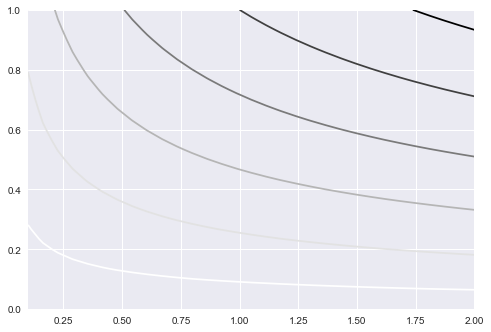

In [10]:
## plot contour
fig, ax = plt.subplots()
ax.contour(X1, X2, Y)

### A Two-dimensional Chebyshev Approximation Algorithm

Analogous to the univariate case, we can state the following algorithm for approximating a function $f(x_1, x_2)$ for $x_1 \in [g^1_{min},g^1_{max}]$ and $x_2 \in [g^2_{min},g^2_{max}]$ using a polynomial of degree $n$ and $m \ge n + 1$ grid points in every dimension:

(i) Compute the $m \ge n + 1$ Chebyshev nodes on $[-1, 1]$: 

\begin{equation}
	z_i = \cos\left(- \frac{(2i - 1)\pi}{2m}\right), \quad i = 1, ..., m
\end{equation}

(ii) Adjust the nodes to the $[g^1_{min},g^1_{max}]$ and $[g^2_{min},g^2_{max}]$ intervals:

\begin{equation}
    x_{1i} = g^1_{min} + \frac{(z_i + 1) (g^1_{max} - g^1_{min})}{2}, \quad\ i = 1,...,m
\end{equation}

\begin{equation}
    x_{2i} = g^2_{min} + \frac{(z_i + 1) (g^2_{max}- g^2_{min})}{2}, \quad\ i = 1,...,m
\end{equation}


Step (i) and (ii) are combined in the Python function **chebgrid** that we have defined in the previous lecture. We can call it from the **fa** module (see above).

In [11]:
m = 10
x1_c = fa.chebgrid(g1_min, g1_max, m)
x2_c = fa.chebgrid(g2_min, g2_max, m)

print(x1_c)

[ 0.11169608  0.2035438   0.37824856  0.61870903  0.90138726  1.19861274
  1.48129097  1.72175144  1.8964562   1.98830392]


(iii) Evaluate $f$ at the approximation nodes:

\begin{equation}
    y_{i_1, i_2} = f(x_{1i_1}, x_{2i_2}), \quad\ i_1 = 1,...,m, \ i_2 = 1,...,m
\end{equation}

In Python, we can use Numpy's **meshgrid** function to get the Cartesian product of the univariate Chebyshev nodes.

In [12]:
X2_c, X1_c = np.meshgrid(x2_c, x1_c)
print(X1_c)

Y_c = cd_fun(X1_c, X2_c) 

[[ 0.11169608  0.11169608  0.11169608  0.11169608  0.11169608  0.11169608
   0.11169608  0.11169608  0.11169608  0.11169608]
 [ 0.2035438   0.2035438   0.2035438   0.2035438   0.2035438   0.2035438
   0.2035438   0.2035438   0.2035438   0.2035438 ]
 [ 0.37824856  0.37824856  0.37824856  0.37824856  0.37824856  0.37824856
   0.37824856  0.37824856  0.37824856  0.37824856]
 [ 0.61870903  0.61870903  0.61870903  0.61870903  0.61870903  0.61870903
   0.61870903  0.61870903  0.61870903  0.61870903]
 [ 0.90138726  0.90138726  0.90138726  0.90138726  0.90138726  0.90138726
   0.90138726  0.90138726  0.90138726  0.90138726]
 [ 1.19861274  1.19861274  1.19861274  1.19861274  1.19861274  1.19861274
   1.19861274  1.19861274  1.19861274  1.19861274]
 [ 1.48129097  1.48129097  1.48129097  1.48129097  1.48129097  1.48129097
   1.48129097  1.48129097  1.48129097  1.48129097]
 [ 1.72175144  1.72175144  1.72175144  1.72175144  1.72175144  1.72175144
   1.72175144  1.72175144  1.72175144  1.72175144]
 

(iv) Compute the Chebyshev coefficients $a_{j_1j _2}$. When using a tensor product basis, we have $ j_1 = 0, ..., n $ and $ j_2 = 0, ..., n $. For complete polynomials of total degree $n$, it must additionally hold that $\sum^2_{k = 1} j_k \le n$.

For $m = n + 1$ and using a tensor product basis, this would imply solving the system of linear equations 

\begin{equation}
y = \Phi_c a =
\left[
\begin{array}{ccccc}
   \mathcal{T}_{0 0} (z_{11}, z_{21}) & \mathcal{T}_{1 0} (z_{11}, z_{21}) & \mathcal{T}_{0 1} (z_{11}, z_{21})  & ... & \mathcal{T}_{n n} (z_{11}, z_{21})  \\
   \mathcal{T}_{0 0} (z_{12}, z_{21}) & \mathcal{T}_{1 0} (z_{12}, z_{21}) & \mathcal{T}_{0 1} (z_{12}, z_{21})  & ... & \mathcal{T}_{n n} (z_{12}, z_{21})  \\
    \vdots & \vdots  & \vdots & \vdots & \vdots  & \vdots \\
    \mathcal{T}_{0 0} (z_{1m}, z_{2m}) & \mathcal{T}_{1 0} (z_{1m}, z_{2m}) & \mathcal{T}_{0 1} (z_{1m}, z_{2m})  & ... & \mathcal{T}_{n n} (z_{1m}, z_{2m})
\end{array}
\right]
\left[
\begin{array}{c}
a_{00} \\
a_{10} \\
a_{01} \\
\vdots \\
a_{nn}
\end{array}
\right]
\end{equation}

More generally, for the number of grid points (usually $m^2$) greater or equal to the number of basis coefficients ($(n + 1)^2$ for a tensor product basis, or a smaller number for complete polynomials), it can be shown that least-squares regression gives the following for $ j_1 = 0, ..., n $ and $ j_2 = 0, ..., n $:

\begin{equation}
    a_{j_1j_2} = \frac{\sum_{i_1 = 1}^m \sum_{i_2 = 1}^m y_{i_1 i_2} T_{j_1}(z_{i_1}) T_{j_2}(z_{i_2})}{ [\sum_{i_1 = 1}^m  T_{j_1}(z_{i_1})^2] [\sum_{i_2 = 1}^m  T_{j_2}(z_{i_2})^2]}
\end{equation}

Deriving this expression follows the same logic as in the univariate case. 

Note that we do not need the two-dimensional Chebyshev matrix seen above in order to implement the fitting step! Instead, the expression above uses only the *univariate* Chebyshev polynomials, and hence we can implement this fitting step using only the one-dimensional Chbyshev matrices. This is done by **chebapprox_2d** defined below:

In [13]:
## two dimensions
def chebapprox_2d(Z, deg):
    """
    Computes the (deg[0]+1)-by-(deg[1]+1) coefficient matrix for approximation with Chebyshev basis functions
    NB: Z must be a m1-by-m2 "meshgrid" matrix
    """
    ## get the dimensions of the grid
    m = Z.shape
    ## check of dimension are consistent
    assert len(m) == len(deg), "Inconsistent dimensions"

    ## define one-dimensional Chebyshev matrices    
    A, B = fa.chebmatrix(deg[0], m[0]), fa.chebmatrix(deg[1], m[1])
    
    ## Tensor interpolation in two dimensions
    coef = np.zeros(np.array(deg) + 1)
    for idx_A in range(deg[0] + 1):
        for idx_B in range(deg[1] + 1):    
            ## compute the denominator
            den = (A[:, idx_A].T @ A[:, idx_A]) * (B[:, idx_B].T @ B[:, idx_B])
            ## compute the coefficients
            coef[idx_A, idx_B] = (A[:, idx_A].T @ Z) @ B[:, idx_B] / den
    
    return coef
         
# print(Z_c.shape)
a = chebapprox_2d(Y_c, [m-1, m-1])

(v) Find the approximant $\hat{f}(x_1, x_2)$, $x_1 \in [g_{min}^1, g_{max}^1]$, $x_2 \in [g_{min}^2, g_{max}^2]$, by evaluating

\begin{equation}
   \hat{f}( x_1, x_2  ) = \sum_{j_1 = 0}^{n} \sum_{j_2 = 0}^{n} a_{j_1 j_2} T_{j_1}\left( 2 \frac{x_1 - g_{min}^1}{g_{max}^1 - g_{min}^1} - 1 \right) T_{j_2}\left( 2 \frac{x_2 - g_{min}^2}{g_{max}^2 - g_{min}^2} - 1 \right)
\end{equation}

Using vector notation, we can also write this step as 

\begin{equation}
\hat{f}( x_1, x_2  ) =
[\mathcal{T}_{0 0} (z_{1}, z_{2})\ \mathcal{T}_{1 0} (z_{1}, z_{2})\ \mathcal{T}_{0 1} (z_{1}, z_{2})\ \ ...\ \mathcal{T}_{n n} (z_{1}, z_{2})]
\left[
\begin{array}{c}
a_{00} \\
a_{10} \\
a_{01} \\
\vdots \\
a_{nn}
\end{array}
\right]
\end{equation}

where $z_{k} = 2 \frac{x_k - g_{min}^k}{g_{max}^k - g_{min}^k} - 1$.

Hence, for this step we need the two-dimensional Chebyshev matrix as seen above:

In [14]:
Phi = np.polynomial.chebyshev.chebvander2d(fa.chebconvert(1.1, g1_min, g1_max), fa.chebconvert(0.8, g2_min, g2_max), [m-1, m-1]) 
Phi @ a.flatten()

array([ 0.88841644])

As a short cut, similar to the univariate case, the **chebval2d** function just implements this step of multiplying the basis functions with the basis coefficients:

In [15]:
np.polynomial.chebyshev.chebval2d(fa.chebconvert(1.1, g1_min, g1_max), fa.chebconvert(0.8, g2_min, g2_max), a)

0.88841644279551457

Below, we use this approach to approximate the Cobb-Douglas function along the first dimension (keeping $x_2$ fixed):

In [16]:
## approximate f along the first dimension 
y_app = np.zeros(N)
for idx in range(N):
    y_app[idx] = np.polynomial.chebyshev.chebval2d(fa.chebconvert(x1[idx], g1_min, g1_max), 
                                                   fa.chebconvert(x2[5], g2_min, g2_max), a)

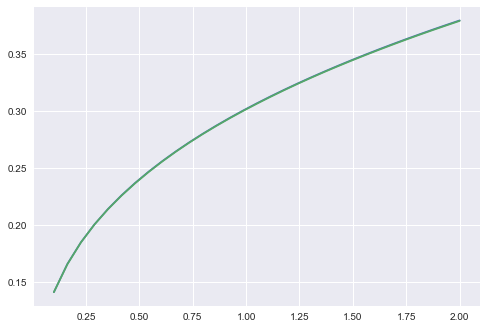

In [17]:
fig, ax = plt.subplots()
ax.plot(x1, cd_fun(x1, x2[5]))
ax.plot(x1, y_app)

As a final note, we have only used a tensor product basis in the approximation above. In the problem set, we will repeat this exercise using complete polynomials. 

--------------------------------------------------------------------------------------------------------------------------------

### Further Topics

In the interest of time, we will not talk in-depth about other topics in the context of function approximation, which are nevertheless highly relevant. 

#### Functional Equations

A slightly more complex application for function approximation than what we have seen so far is the case where we do not know $f$ explicitly, but where its values are determined *implicitly* by a functional equation.


For example, in the first example in lecture 1, we got a first-order condition that determined consumption of a good $c_1$ as a function of initial endowment $x$:

\begin{equation}
    [x - \tilde{c}_1(x)]^{\alpha\nu - \alpha + 1} - \alpha \tilde{c}_1(x)^\nu = 0. 
\end{equation}

This is an example of a functional equation $g(x, f(x)) = 0$ where the function $g$ is given, while $f$ is unknown. Note that the solution to a functional equation is not just a scalar or vector (as in all the problems considered so far), but a function which is defined at infinitely many points. 

Functional equation typically lack explicit closed-form solutions, and hence we look for approximate solutions $\hat{f}$. 

#### Hermite Interpolation

In the context of interpolation, we have so far considered *Lagrange* interpolation, which uses information only on the levels of a function. In other words, we have one interpolation condition per grid point (see the previous notebook), and the data is given by $\{y_i, x_i\}_{i = 1}^m$.

*Hermite interpolation* also uses information on the *slope* of the function. Hence, for $m$ grid points, we have $2m$ interpolation conditions, with the data given by:  

\begin{equation}
    \{y_i, y'_i, x_i\}_{i = 1}^m
\end{equation}

where $y'_i = f'(x_i)$. Since the degree of approximation/number of basis coefficients must match the number of interpolation conditions, we use $n = 2m - 1$ basis functions.

Intuitively, Hermite interpolation uses more information about the function, and hence can provide a "better" approximation of the function.

#### Other Family of Basis Functions: Splines

So far, we have considered one family of basis functions, polynomials. As mentioned in the previous lecture, approximating a function with a polynomial is an example of a "spectral method", which uses basis functions that are nonzero over the entire domain of the function that is approximated (except at a *finite* number of points). 

The other option are *finite element* method which relies on basis functions that are nonzero only over subintervals of the approximation domain. The prime example for this method are *piecewise polynomial splines*. An order-$k$ spline consists of a series of $k$th-order polynomial segments spliced together so as to preserve the continuity of the derivatives of order $k-1$ or less (cp. M & F, chapter 6.4). 

The cubic spline basis functions for $k = 3$ are shown below.

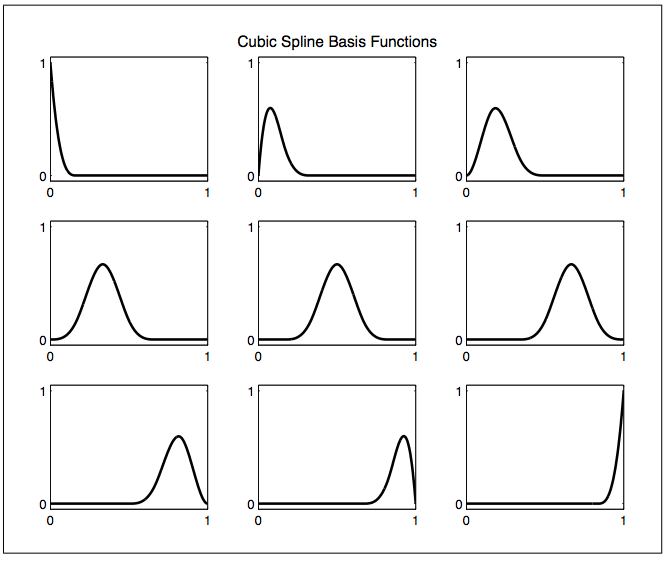

In [18]:
display.Image('splines.png')

When should you use splines rather than a polynomial basis? The main criterion here is whether the function that you want to approximate is sufficiently "smooth" or if it has a high degree of curvature and/or "kinks", i.e. a discontinuity in the first or second derivatives. In the first case, approximating the function with Chebyshev polynomials and nodes is the best strategy. In the second case, since splines can deal much better with discontinuities, they are typically the better choice.  

In this class, all functions that we will need to approximate from this point on will be smooth enough for Chebyshev polynomials to be our method of choice.

On this topic, let's also consider Boyd's Moral Principle (via J. Fernandez-Villaverde):
1. When in doubt, use Chebyshev polynomials (unless the solution is spatially periodic, in which case an ordinary Fourier series is better).
2. Unless you are sure that another set of basis functions is better, use Chebyshev polynomials.
3. Unless you are really, really sure that another set of basis functions is better, use Chebyshev polynomials.